# Etap 3.
## Wczytanie przetworzonych danych po PCA z plików "prepared_features_after_PCA_(train/val/test).csv"
## Przygotowanie etykiet klasowych (jeśli dotyczy)
## Trening i testowanie różnych modeli 
## Ewaluacja i porównanie modeli
## Wizualizacja wyników


In [1]:
import pandas as pd
import math  

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn_extra.cluster import KMedoids

from sklearn.neighbors import NearestNeighbors

import plotly.express as px
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ścieżki do plików
split_names = ['train', 'val', 'test']
paths = [f"Data/Concatenated Features/prepared_features_after_PCA_{split}.csv" for split in split_names]

# Wczytanie danych do listy
X_pca = [pd.read_csv(path) for path in paths]
# X_pca[0] - train
# X_pca[1] - val
# X_pca[2] - test


In [3]:
def prepare_X(df):
    return df.drop(columns=['Nazwa']) if 'Nazwa' in df.columns else df

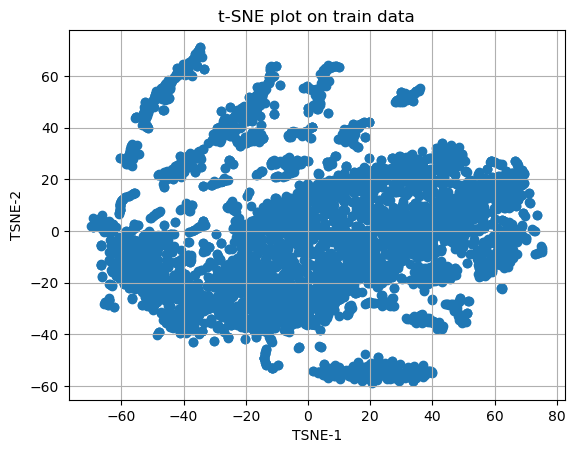

In [4]:
X_input =prepare_X(X_pca[0]) 

# t-SNE na danych treningowych
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(X_input)

# Wykres
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE plot on train data')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.grid(True)
plt.show()

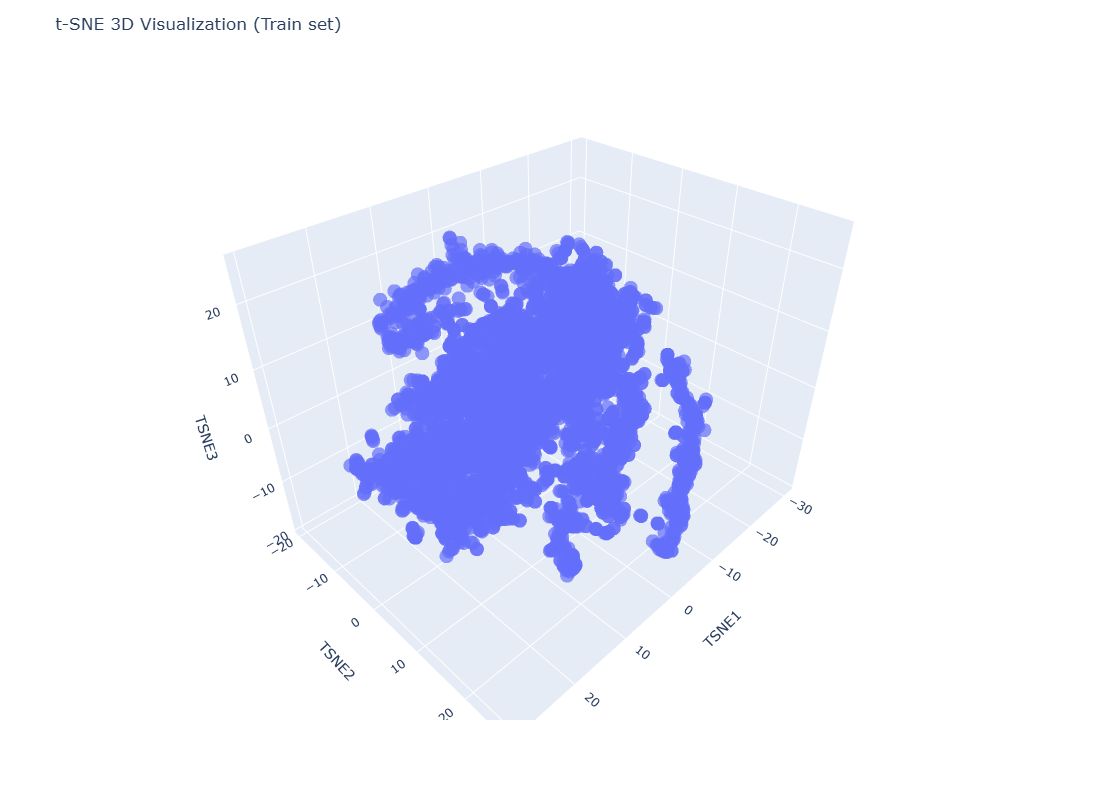

In [5]:
X_input =prepare_X(X_pca[0]) 

# t-SNE 3D na danych treningowych
tsne = TSNE(n_components=3, perplexity=40, random_state=42)
X_tsne_3d = tsne.fit_transform(X_input)

# Przygotowanie DataFrame
df_tsne = pd.DataFrame(X_tsne_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'])


# Interaktywny wykres 3D
fig = px.scatter_3d(df_tsne, x='TSNE1', y='TSNE2', z='TSNE3', opacity=0.7)
fig.update_layout(title='t-SNE 3D Visualization (Train set)', width=1000, height=800)
fig.show()


In [6]:
def evaluate_clustering(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return {"Method": name, "Silhouette": sil, "Davies-Bouldin": db, "Calinski-Harabasz": ch}

In [7]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

def fit_predict_all_splits(model, X_pca, model_name="Model"):
    """
    model: instancja modelu klasteryzacyjnego (np. KMeans, AgglomerativeClustering, DBSCAN, itp.)
    X_pca: lista [X_train_df, X_val_df, X_test_df] (np. z read_csv)
    prepare_X: funkcja do przygotowania danych (np. usunięcia kolumny 'Nazwa')
    model_name: nazwa modelu (string) do użycia jako klucz

    Zwraca:
        labels_dict: słownik {split: {model_name: labels}}
    """
    splits = ['train', 'val', 'test']
    labels_dict = {split: {} for split in splits}

    X_train = prepare_X(X_pca[0]).to_numpy()
    model = clone(model)  # bezpieczna kopia

    try:
        # Fit na treningu
        labels_train = model.fit_predict(X_train)
        labels_dict['train'][model_name] = labels_train

        # Przewidywanie dla val/test
        if hasattr(model, 'predict'):
            for i, split in enumerate(['val', 'test'], start=1):
                X_other = prepare_X(X_pca[i])
                labels_other = model.predict(X_other)
                labels_dict[split][model_name] = labels_other
        else:
            # KNN z jednym sąsiadem na centroidach
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_train, labels_train)
            for i, split in enumerate(['val', 'test'], start=1):
                X_other = prepare_X(X_pca[i]).to_numpy()
                labels_other = knn.predict(X_other)
                labels_dict[split][model_name] = labels_other

    except Exception as e:
        print(f"Błąd dla modelu '{model_name}': {e}")

    return labels_dict


In [8]:
results = {}
labels_dict = {
    "train": {},
    "val": {},
    "test": {}
}

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of

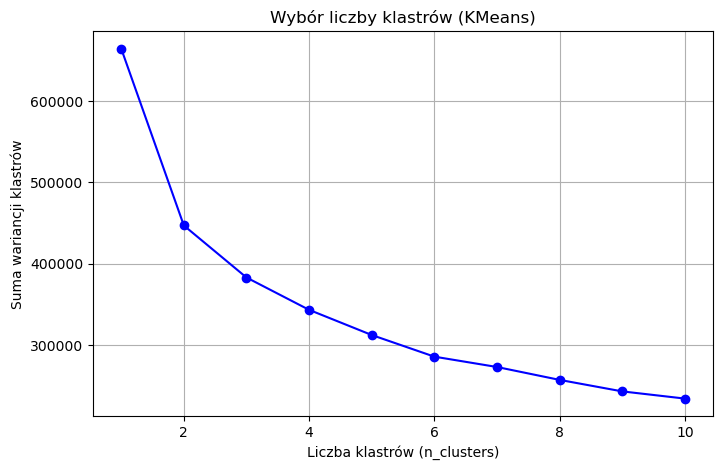

In [9]:
# Przygotowanie danych
X_prepared =prepare_X(X_pca[0]) 

# Zakres liczby klastrów do przetestowania
cluster_range = range(1, 11)
suma_wariancji_klastrow = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prepared)
    suma_wariancji_klastrow.append(kmeans.inertia_)  # inertia = suma wariancji klastrów

# Rysowanie wykresu
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, suma_wariancji_klastrow, 'bo-')
plt.xlabel('Liczba klastrów (n_clusters)')
plt.ylabel('Suma wariancji klastrów')
plt.title('Wybór liczby klastrów (KMeans)')
plt.grid(True)
plt.show()


In [10]:
# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels_dict_kmeans = fit_predict_all_splits(kmeans, X_pca, model_name="KMeans")

for split in ['train', 'val', 'test']:
    labels_dict[split].update(labels_dict_kmeans[split])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but KMeans was fitted without feature names

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but KMeans was fitted without feature names



In [11]:
# Agglomerative Clustering

from sklearn.neighbors import NearestCentroid

linkages = ['ward', 'complete', 'average', 'single']
splits = ['train', 'val', 'test']
labels_dict = {split: {} for split in splits}

for linkage in linkages:
    agglo = AgglomerativeClustering(n_clusters=5, linkage=f"{linkage}")
    labels_dict_agglo = fit_predict_all_splits(agglo, X_pca,  model_name=f"Agglomerative {linkage}")
    # scal do głównego słownika
    for split in splits:
        labels_dict[split].update(labels_dict_agglo[split])




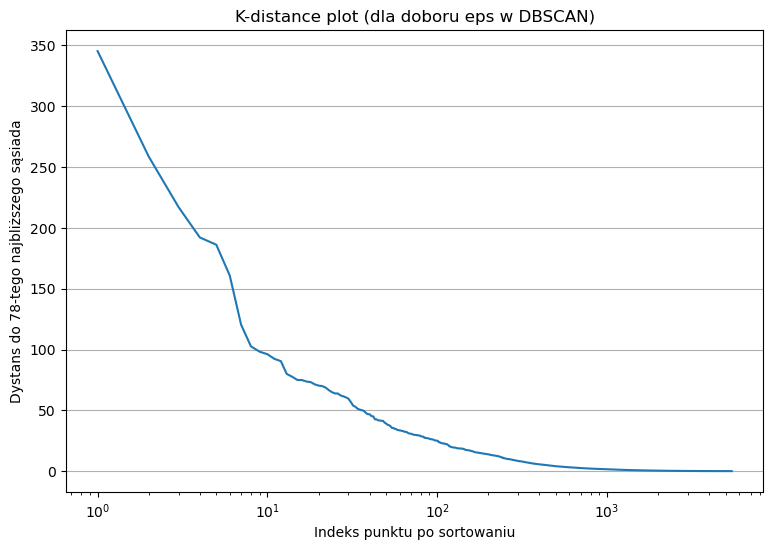

In [12]:
minPts = 2 *prepare_X(X_pca[0]).shape[1]  # min_samples
nbrs = NearestNeighbors(n_neighbors=minPts).fit(prepare_X(X_pca[0]))
distances, indices = nbrs.kneighbors(prepare_X(X_pca[0]))

# Posortuj dystanse do minPts-tego sąsiada
distanceDec = sorted(distances[:, minPts - 1], reverse=True)

# Wykres
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111)
ax1.plot(range(1, X_pca[0].shape[0] + 1), distanceDec)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel(f'Dystans do {minPts}-tego najbliższego sąsiada')
plt.xscale('log')
plt.grid(axis='y')
plt.title('K-distance plot (dla doboru eps w DBSCAN)')
plt.show()

In [13]:
# DBSCAN
dbscan = DBSCAN(eps=125, min_samples= round(1/8*prepare_X(X_pca[0]).shape[1]))
labels_dbscan = fit_predict_all_splits(dbscan, X_pca, model_name="DBSCAN")
for split in labels_dbscan:
    labels_dict[split].update(labels_dbscan[split])

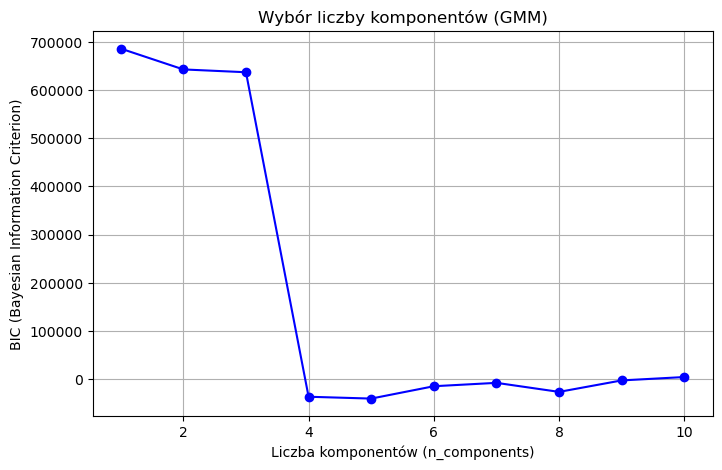

In [14]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Przygotowanie danych
X_prepared = prepare_X(X_pca[0])

# Zakres liczby komponentów do przetestowania
component_range = range(1, 11)
bic_values = []

for k in component_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_prepared)
    bic_values.append(gmm.bic(X_prepared))  # Im mniejsze BIC, tym lepiej

# Rysowanie wykresu
plt.figure(figsize=(8, 5))
plt.plot(component_range, bic_values, 'bo-')
plt.xlabel('Liczba komponentów (n_components)')
plt.ylabel('BIC (Bayesian Information Criterion)')
plt.title('Wybór liczby komponentów (GMM)')
plt.grid(True)
plt.show()


In [15]:
# Gaussian Mixture
gmm = GaussianMixture(n_components=5, random_state=42)
labels_gmm = fit_predict_all_splits(gmm, X_pca, model_name="GMM")
for split in labels_gmm:
    labels_dict[split].update(labels_gmm[split])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but GaussianMixture was fitted without feature names

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but GaussianMixture was fitted without feature names



C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 12 is empty! self.labels_[self.medoid_indic

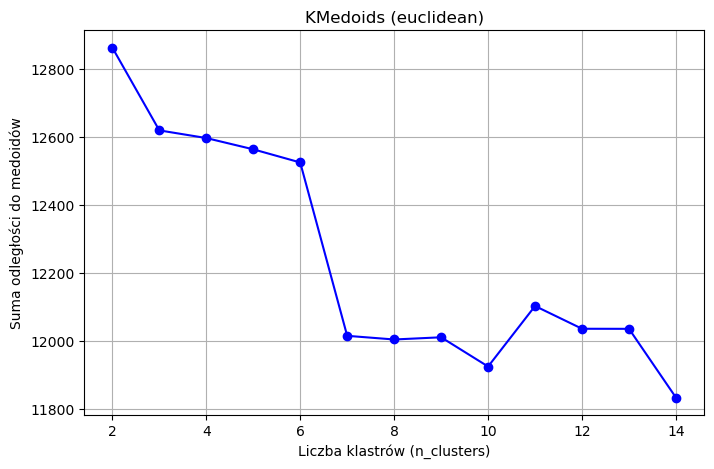

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[

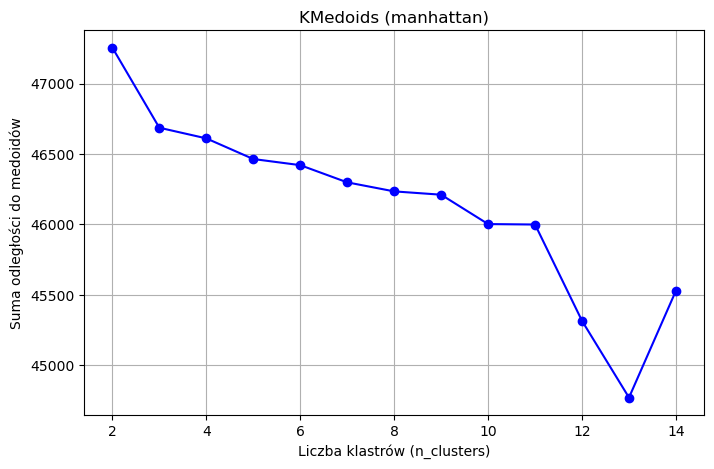

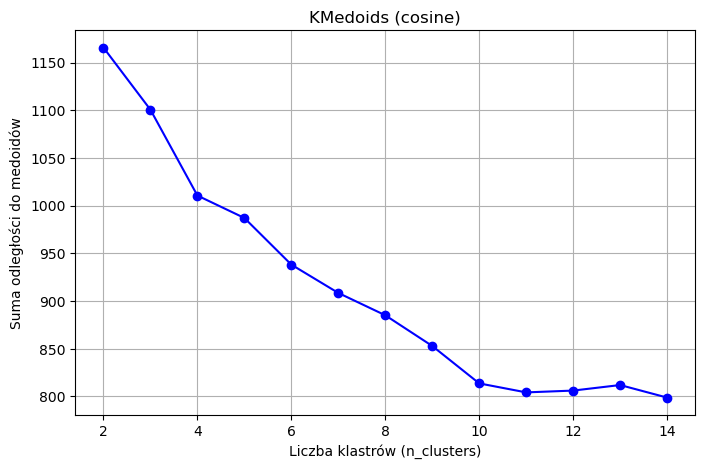

In [16]:
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

# Przygotowanie danych
X_prepared = prepare_X(X_pca[0])

# Zakres liczby klastrów
cluster_range = range(2, 15)  # od 2, bo silhouette nie działa dla 1 klastra
medoid_metrics = ['euclidean', 'manhattan', 'cosine']

for metric in medoid_metrics:
    suma_odleglosci = []

    for k in cluster_range:
        kmedoids = KMedoids(n_clusters=k, metric=metric, random_state=42)
        kmedoids.fit(X_prepared)
        # suma odległości punktów do medoidów (inertia-like)
        suma_odleglosci.append(kmedoids.inertia_)

    # Rysowanie wykresu
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, suma_odleglosci, 'bo-')
    plt.xlabel('Liczba klastrów (n_clusters)')
    plt.ylabel('Suma odległości do medoidów')
    plt.title(f'KMedoids ({metric})')
    plt.grid(True)
    plt.show()


In [17]:
# KMedoids z kilkoma metrykami
medoid_metrics = ['euclidean', 'manhattan', 'cosine']

for metric in medoid_metrics:
    kmedoids = KMedoids(n_clusters=9, metric=metric, random_state=42)
    labels_kmedoids = fit_predict_all_splits(kmedoids, X_pca, model_name=f"KMedoids ({metric})")
    
    # Scal do globalnego słownika
    for split in labels_kmedoids:
        labels_dict[split].update(labels_kmedoids[split])


C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).



In [18]:
results = []

for split in ['train', 'val', 'test']:
    X_split = prepare_X(X_pca[['train', 'val', 'test'].index(split)]).to_numpy()
    for method_name, labels in labels_dict[split].items():
        unique_labels = set(labels)
        if len(unique_labels) < 2:
            print(f"Pomijam {method_name} na zbiorze {split} bo jest tylko {len(unique_labels)} klaster(-y)")
            continue
        res = evaluate_clustering(X_split, labels, f"{method_name} ({split})")
        results.append(res)

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


Pomijam Agglomerative complete na zbiorze val bo jest tylko 1 klaster(-y)
Pomijam Agglomerative average na zbiorze val bo jest tylko 1 klaster(-y)
Pomijam Agglomerative single na zbiorze val bo jest tylko 1 klaster(-y)
Pomijam DBSCAN na zbiorze val bo jest tylko 1 klaster(-y)
                            Method  Silhouette  Davies-Bouldin  \
0       Agglomerative ward (train)    0.928791        0.983703   
1   Agglomerative complete (train)    0.976323        0.614347   
2    Agglomerative average (train)    0.976323        0.614347   
3     Agglomerative single (train)    0.978150        0.011293   
4                   DBSCAN (train)    0.981510        0.761669   
5                      GMM (train)    0.361869        1.561917   
6     KMedoids (euclidean) (train)   -0.370288        3.394561   
7     KMedoids (manhattan) (train)   -0.413025        4.664240   
8        KMedoids (cosine) (train)    0.224959        3.171772   
9         Agglomerative ward (val)    0.913073        0.972887 

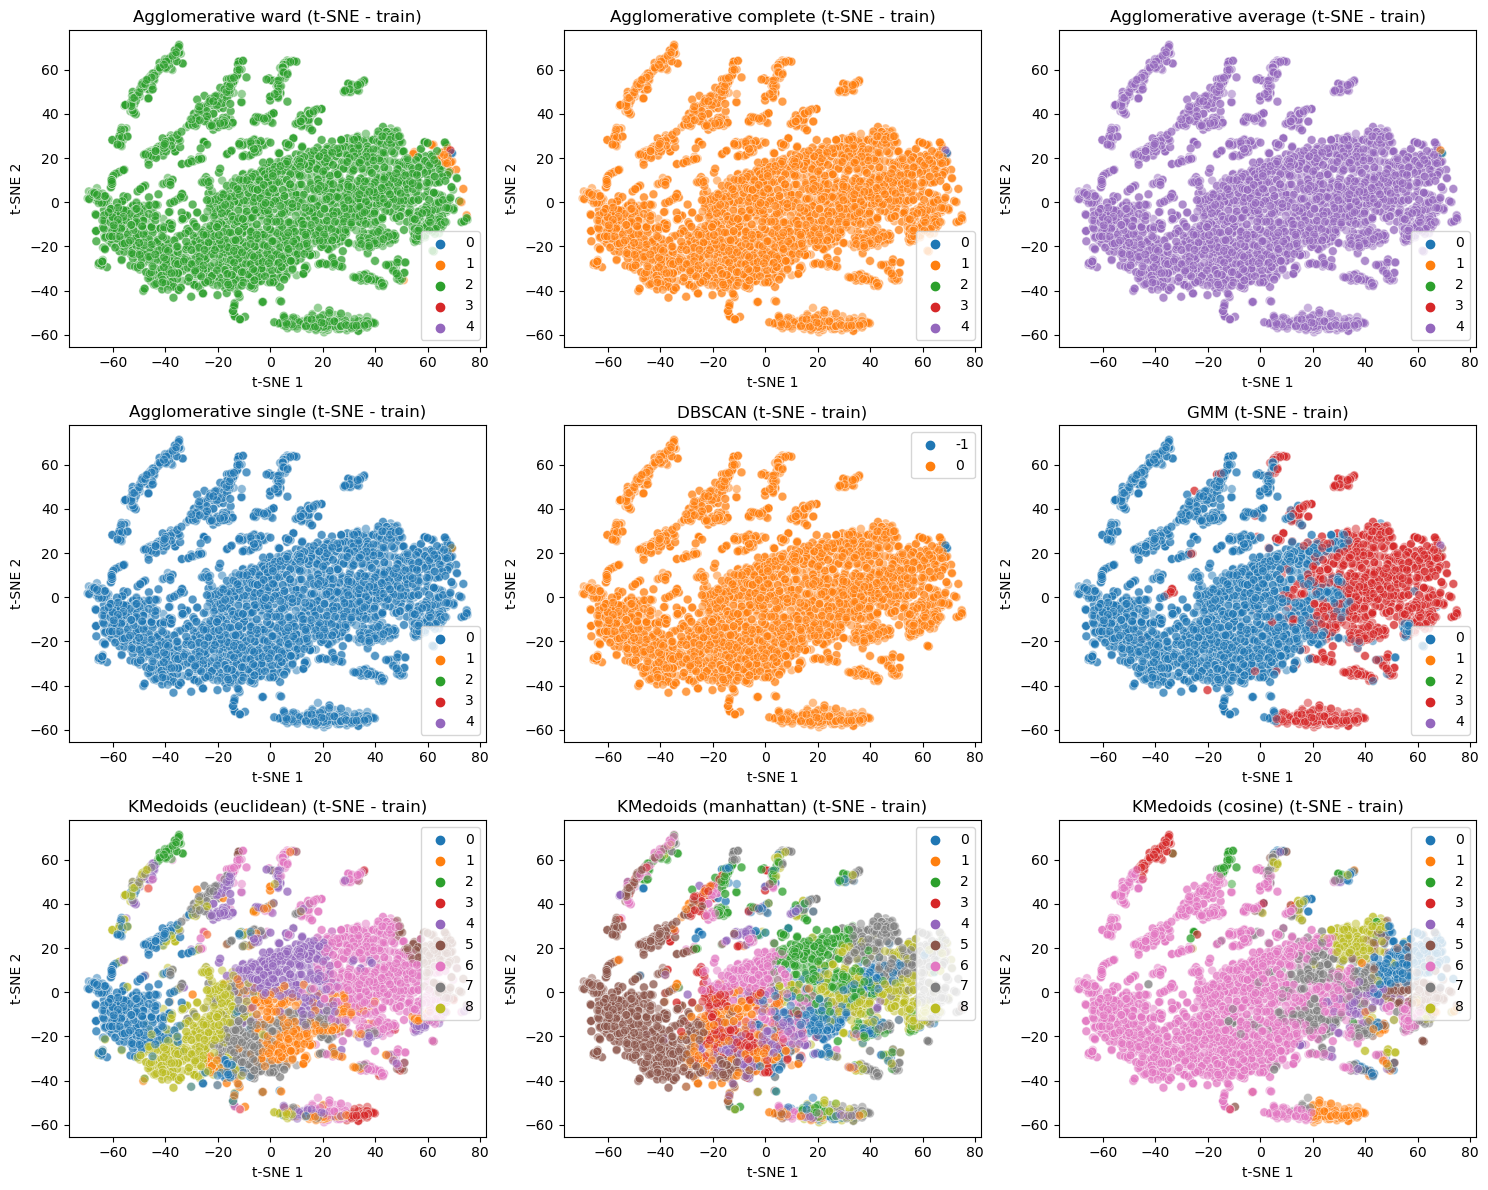

In [19]:
# Funkcja do wizualizacji klastrów 2D
def plot_embedding_split(X_embedded, method_name, labels_for_split, split_name):
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    n = len(labels_for_split)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (method, labels) in enumerate(labels_for_split.items()):
        ax = axes[i]
        sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', ax=ax,
                        s=40, alpha=0.5, legend='full')
        ax.set_title(f"{method} ({method_name} - {split_name})")
        ax.set_xlabel(f"{method_name} 1")
        ax.set_ylabel(f"{method_name} 2")
        ax.legend(loc='best')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# Wizualizacja
X_train_embedded = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(prepare_X(X_pca[0]))
plot_embedding_split(X_train_embedded, "t-SNE", labels_dict["train"], "train")

# Analogicznie dla val/test
#X_val_embedded = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(prepare_X(X_pca[1]))
#plot_embedding_split(X_val_embedded, "t-SNE", labels_dict["val"], "val")

#X_test_embedded = TSNE(n_components=2, perplexity=10, random_state=42).fit_transform(prepare_X(X_pca[2]))
#plot_embedding_split(X_test_embedded, "t-SNE", labels_dict["test"], "test")

In [20]:
# Funkcja do wizualizacji klastrów 3D

# Przygotowanie danych
X_train = prepare_X(X_pca[0])

# t-SNE 3D na pełnym zbiorze (bez wykrywania i usuwania outlierów)
X_tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42).fit_transform(X_train)

# KMedoids z metryką Manhattan
kmedoids = KMedoids(n_clusters=5, metric='manhattan', init='heuristic', random_state=42)
labels = kmedoids.fit_predict(X_train)

# DataFrame do wizualizacji
df_3d = pd.DataFrame({
    'TSNE1': X_tsne_3d[:, 0],
    'TSNE2': X_tsne_3d[:, 1],
    'TSNE3': X_tsne_3d[:, 2],
    'Cluster': labels.astype(str)
})

# Mapa kolorów – zamiana koloru klastra '4' na czarny
color_map = {
    '0': '#1f77b4',  # niebieski
    '1': '#ff7f0e',  # pomarańczowy
    '2': '#2ca02c',  # zielony
    '3': '#d62728',  # czerwony
    '4': '#000000'   # czarny (zamiast fioletu)
}

# Interaktywny wykres
fig = px.scatter_3d(df_3d, x='TSNE1', y='TSNE2', z='TSNE3',
                    color='Cluster',
                    color_discrete_map=color_map,
                    title="KMedoids (Manhattan) – pełny zbiór bez outlierów",
                    opacity=0.75,
                    width=1000, height=800)
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(
    xaxis_title='TSNE1',
    yaxis_title='TSNE2',
    zaxis_title='TSNE3'
))
fig.show()

#X_val_embedded_3d = TSNE(n_components=3, perplexity=10, random_state=42).fit_transform(prepare_X(X_pca[1]))
#plot_embedding_split_3d(X_val_embedded_3d, "t-SNE", labels_dict["val"], "val")

#X_test_embedded_3d = TSNE(n_components=3, perplexity=10, random_state=42).fit_transform(prepare_X(X_pca[2]))
#plot_embedding_split_3d(X_test_embedded_3d, "t-SNE", labels_dict["test"], "test")


C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).



In [21]:
# Przygotowanie danych
X_train = prepare_X(X_pca[0])

# t-SNE 3D na pełnym zbiorze (bez wykrywania i usuwania outlierów)
X_tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42).fit_transform(X_train)

# KMedoids z metryką Manhattan
kmedoids = KMedoids(n_clusters=5, metric='manhattan', init='heuristic', random_state=42)
labels = kmedoids.fit_predict(X_train)

# DataFrame do wizualizacji
df_3d = pd.DataFrame({
    'TSNE1': X_tsne_3d[:, 0],
    'TSNE2': X_tsne_3d[:, 1],
    'TSNE3': X_tsne_3d[:, 2],
    'Cluster': labels.astype(str)
})

# Mapa kolorów – zamiana koloru klastra '4' na czarny
color_map = {
    '0': '#1f77b4',  # niebieski
    '1': '#ff7f0e',  # pomarańczowy
    '2': '#2ca02c',  # zielony
    '3': '#d62728',  # czerwony
    '4': '#000000'   # czarny (zamiast fioletu)
}

# Interaktywny wykres
fig = px.scatter_3d(df_3d, x='TSNE1', y='TSNE2', z='TSNE3',
                    color='Cluster',
                    color_discrete_map=color_map,
                    title="KMedoids (Manhattan)",
                    opacity=0.75,
                    width=1000, height=800)
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(
    xaxis_title='TSNE1',
    yaxis_title='TSNE2',
    zaxis_title='TSNE3'
))
fig.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning:

Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).



In [22]:
X_with_labels = X_train.copy()
X_with_labels_df = pd.DataFrame(X_with_labels)
X_with_labels_df['Cluster'] = labels

# Średnie wartości cech w klastrach
cluster_means = X_with_labels_df.groupby('Cluster').mean()

# Odchylenia standardowe cech w klastrach
cluster_stds = X_with_labels_df.groupby('Cluster').std()

# Wyświetlenie
print("Średnie cech w klastrach:\n", cluster_means)
print("\nOdchylenia standardowe cech w klastrach:\n", cluster_stds)

Średnie cech w klastrach:
                 0         1         2         3         4         5         6  \
Cluster                                                                         
0        3.373565 -0.874452  0.992487 -0.501525  0.205821 -0.655057 -0.046864   
1       -0.885393  0.182628 -0.231914  0.177586 -0.000341  0.152046 -0.046810   
2       -0.714764  0.175426 -0.210082  0.124180 -0.000018  0.156119  0.241115   
3       -0.856311  0.171544 -0.229105  0.168159 -0.000439  0.154784 -0.029929   
4        0.136870  0.159990 -0.060746 -0.205390 -0.234704  0.020914 -0.008823   

                7         8         9  ...        29        30        31  \
Cluster                                ...                                 
0        0.677647  0.320700  0.374741  ... -0.113191  0.047669  0.294716   
1       -0.215818 -0.071136 -0.073656  ...  0.063749 -0.021071 -0.096881   
2       -0.086837 -0.063565 -0.063159  ... -0.044322 -0.019267  0.037023   
3       -0.196821 -0.0576

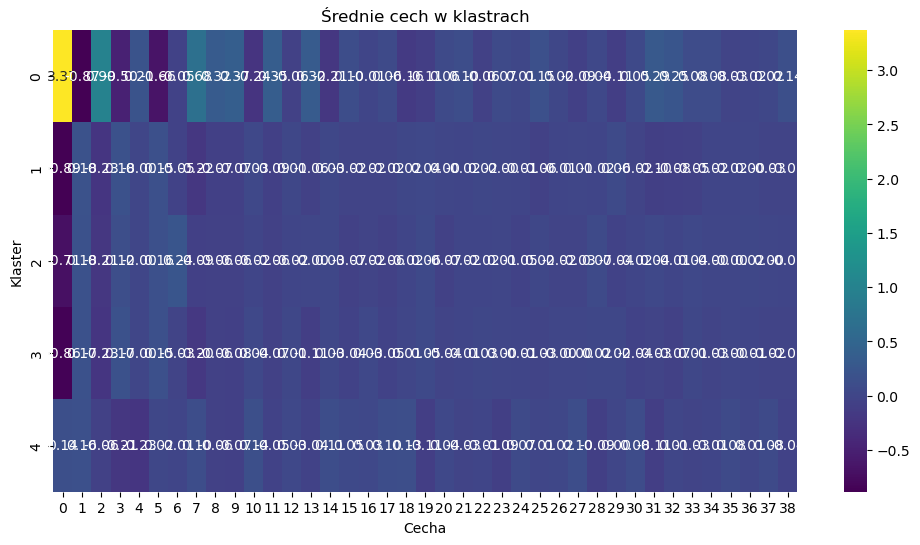

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, cmap='viridis', annot=True, fmt='.2f')
plt.title('Średnie cech w klastrach')
plt.xlabel('Cecha')
plt.ylabel('Klaster')
plt.show()

In [24]:
X_scaled_train = pd.read_csv('X_scaled_train.csv')

# Przygotuj dane, usuwając kolumnę 'Nazwa', jeśli istnieje
def prepare_X(df):
    return df.drop(columns=['Nazwa']) if 'Nazwa' in df.columns else df

X_scaled_train_prepared = prepare_X(X_scaled_train)

# Dodaj etykiety klastrów do danych
X_scaled_train_prepared['Cluster'] = labels

# Oblicz statystyki opisowe dla każdego klastra
cluster_stats_original = X_scaled_train_prepared.groupby('Cluster').mean()
cluster_std_original = X_scaled_train_prepared.groupby('Cluster').std()

# Wyświetl statystyki opisowe
print("Średnie wartości cech dla każdego klastra:")
print(cluster_stats_original)

print("\nOdchylenia standardowe cech dla każdego klastra:")
print(cluster_std_original)

Średnie wartości cech dla każdego klastra:
          Unnamed: 0  suma pośrednia  rezerwy długoterminowe  \
Cluster                                                        
0        2780.257206        0.271763                0.315969   
1        2739.217267       -0.077125               -0.084391   
2        2616.674253       -0.056937               -0.070558   
3        2682.351246       -0.074092               -0.085362   
4        2703.348601        0.031708                0.027738   

         amortyzacja i umorzenia  \
Cluster                            
0                       0.472479   
1                      -0.115588   
2                      -0.109146   
3                      -0.117060   
4                       0.003846   

         kapitał własny przypadający akcjonariuszom jednostki dominującej  \
Cluster                                                                     
0                                                 0.667193                  
1                       

In [25]:
# Zapisz do plików
cluster_stats_original.to_csv('cluster_means.csv')
cluster_std_original.to_csv('cluster_stddevs.csv')

In [26]:
print(cluster_stats_original['Unnamed: 0'])

Cluster
0    2780.257206
1    2739.217267
2    2616.674253
3    2682.351246
4    2703.348601
Name: Unnamed: 0, dtype: float64


In [27]:

# Zdefiniuj nowe nazwy kolumn w kontekście ekonomicznym
new_column_names = {
    "Cluster": "Grupa",
    "Unnamed: 0": "Indeks",
    "(SubTotal)": "Całkowity Przychód",
    "Przepisy długoterminowe": "Długoterminowe Rezerwy",
    "Amortyzacja i straż pożarna": "Amortyzacja i Wydatki na Bezpieczeństwo",
    "Kapitał partnerstwa głównego": "Główne Udziały Kapitałowe",
    "Akcje mniejszościowe": "Udziały Mniejszościowe",
    "Przepisy zadłużenia": "Rezerwy na Zadłużenie",
    "Żywe istoty": "Aktywa Biologiczne",
    "Zachęta państwowa i pomoc": "Zachęty i Pomoc Rządowa",
    "Zwiększenie wartości fundusze": "Wzrost Wartości Funduszu",
    "Inne należności": "Pozostałe Należności",
    "Inne długi": "Pozostałe Zobowiązania",
    "Inne stałe aktywa": "Pozostałe Aktywa Trwałe",
    "Inne obracające się zasoby": "Pozostałe Aktywa Obrotowe",
    "Inne zobowiązania finansowe": "Pozostałe Zobowiązania Finansowe",
    "Inne dochody i wydatki": "Pozostałe Przychody i Koszty",
    "Inne dochody/wydatki": "Pozostałe Przychody/Koszty",
    "Inne krótkoterminowe zobowiązania": "Pozostałe Krótkoterminowe Zobowiązania",
    "Inne długoterminowe zobowiązania": "Pozostałe Długoterminowe Zobowiązania",
    "Inne dochody podatkowe (wydatki)": "Pozostałe Przychody/Koszty Podatkowe",
    "Gotówka z innych działań inwestycyjnych": "Gotówka z Innych Działalności Inwestycyjnych",
    "Inne ołówki Selfer": "Pozostałe Ołówki Selfer",
    "Gotówka z innych działalności biznesowej": "Gotówka z Innych Działalności Biznesowych",
    "Zobowiązanie podatkowe zysków terminowych": "Obowiązek Podatkowy od Zysków Okresowych",
    "Śnieg netto/uszkodzenie tego okresu": "Netto Zysk/Strata za Okres",
    "Dochody podatkowe (wydatki)": "Przychody/Koszty Podatkowe",
    "Odroczone przychody (Word Klient Word. Dogan Load. Zewnętrzna. Kal.)": "Przychody Przesunięte",
    "Odroczone dochody podatkowe (wydatki)": "Przesunięte Przychody/Koszty Podatkowe",
    "Przełożona obecność podatkowa": "Aktywa z Tytułu Odroczonego Podatku",
    "Odroczony obowiązek podatkowy": "Zobowiązania z Tytułu Odroczonego Podatku",
    "Otrzymane z działalności sektora finansowego": "Otrzymane z Działalności Sektora Finansowego",
    "Długi z działalności sektora finansowego": "Zobowiązania z Działalności Sektora Finansowego",
    "Długi finansowe": "Zobowiązania Finansowe",
    "Inwestycje finansowe": "Inwestycje Finansowe",
    "Minione lata śnieg/straty": "Zysk/Strata z Lat Ubiegłych",
    "Zapasy premii eksportowe": "Zapasy Premiowe Eksportowe",
    "Ograniczone kopie zapasowe oddzielone od śniegu": "Ograniczone Kopie Zapasowe Oddzielone od Zysku",
    "Zmiana przepisów": "Zmiana w Przepisach",
    "Korekta kapitału wzajemnego uczestnictwa (-)": "Korekta Kapitału Wzajemnego Udziału",
    "Prawo do używania aktywów": "Prawo do Używania Aktywów",
    "Materialne zasoby stojące": "Materialne Aktywa Trwałe",
    "Istoty niematerialne": "Niematerialne Aktywa Trwałe",
    "Obietnica klienta. Obciążenie Dogan.": "Obietnica Klienta, Opłata Dogan",
    "Słowo klienta.": "Słowo Klienta",
    "Aktywa wynikające z umów o klienta": "Aktywa z Umów z Klientami",
    "Gotówka i gotówka": "Gotówka i Ekwiwalenty Gotówki",
    "Stałe inwestycje kapitałowe": "Inwestycje w Kapitał Stały",
    "Stałe aktywa trzymane ręcznie na sprzedaż": "Aktywa Trwałe Przeznaczone do Sprzedaży",
    "Zobowiązania do stałych aktywów posiadanych do celów sprzedaży": "Zobowiązania z Tytułu Aktywów Trwałych Przeznaczonych do Sprzedaży",
    "Dyby": "Bloki",
    "Należności komercyjne": "Należności Handlowe",
    "Długi handlowe": "Zobowiązania Handlowe",
    "Różnice w cyklu walut obcych": "Różnice Kursowe",
    "Nieruchomości do celów inwestycyjnych": "Nieruchomości Inwestycyjne",
    "Dochód z działalności inwestycyjnej": "Przychody z Działalności Inwestycyjnej",
    "Wydatki z działalności inwestycyjnej (-)": "Koszty Działalności Inwestycyjnej",
    "Relacje z korzyściami udzielonymi pracownikom.": "Relacje z Tytułu Świadczeń Pracowniczych",
    "Płatny kapitał": "Wpłacony Kapitał",
    "Inwestycje oceniane metodą siebie": "Inwestycje Wyceniane Metodą Wewnętrzną",
    "Zmiany kapitału obrotowego": "Zmiany w Kapiatele Obrotowym",
    "Honor": "Honorarium",
    "Inne wejście/wyjście gotówkowe": "Pozostałe Przepływy Gotówkowe",
    "Śnieg przed korektą": "Zysk Przed Korektą",
    "Korekty:": "Korekty",
    "Gotówka (+)": "Dodatnia Gotówka",
    "Yab.i Cycle Cycle. Gotówka i gotówka Benz. Wpływ na": "Wpływ Cyklu Yab.i na Gotówkę",
    "Gotówka spowodowana działalnością inwestycyjną": "Gotówka z Działalności Inwestycyjnej",
    "Gotówka netto pochodząca z działalności gospodarczej": "Netto Gotówka z Działalności Operacyjnej",
    "Przed zmianami kapitału obrotowego (+)": "Przed Zmianami w Kapiatele Obrotowym (Dodatnie)",
    "(Głównie poza działalnością) dochód finansowy": "Głównie Pozostałe Przychody Finansowe",
    "(Głównie poza działalnością) Koszty finansowe (-)": "Głównie Pozostałe Koszty Finansowe",
    "Koszty amortyzacji": "Koszty Amortyzacji",
    "Główne akcje partnerstwa": "Główne Udziały Partnerstwa",
    "Koszty badań i rozwoju (-)": "Koszty Badań i Rozwoju",
    "Akcje mniejszościowe.1": "Udziały Mniejszościowe 1",
    "Razący śnieg (uszkodzenie)": "Zburzenie Zysku/Straty",
    "Zatrzymane zajęcia": "Zyski Zatrzymane",
    "Inne dochody z działalności": "Pozostałe Przychody Operacyjne",
    "Inne wydatki na działalność (-)": "Pozostałe Koszty Operacyjne",
    "Gotówka z innych działań finansowych": "Gotówka z Innych Działalności Finansowych",
    "Inne dochody i wydatki.1": "Pozostałe Przychody i Koszty 1",
    "Wzrost innych gotówki i gotówki podobny": "Wzrost Pozostałej Gotówki i Ekwiwalentów",
    "Aktywa stojące": "Aktywa Stojące",
    "Zatrzymane zajęcia po okresie życia (szkody)": "Zyski Zatrzymane Po Okresie Życia (Straty)",
    "Z okresem życia (szkody)": "Straty z Okresu Życia",
    "Wartości gotówkowe na początku okresu": "Wartości Gotówkowe na Początek Okresu",
    "Rozkład okresu śniegu/uszkodzenia": "Rozłożenie Zysku/Straty w Okresie",
    "Koniec okresu gotówki": "Gotówka na Koniec Okresu",
    "Obracające się aktywa": "Aktywa Obrotowe",
    "Zysk aktywności (szkody)": "Zysk/Strata z Działalności",
    "Inne dochody i wydatki przed zyskiem operacyjnym": "Pozostałe Przychody i Koszty Przed Wynikiem Operacyjnym",
    "Odsetki, płace, składki, prowizja i inne dochody": "Odsetki, Wynagrodzenia, Składki, Prowizje i Pozostałe Przychody",
    "Odsetki, wynagrodzenie, premia, prowizja i inne wydatki (-)": "Odsetki, Odszkodowania, Premie, Prowizje i Pozostałe Koszty",
    "Zysk brutto z działalności sektora finansowego (strata)": "Brutto Zysk/Strata z Działalności Sektora Finansowego",
    "Inny zysk z działań sektorowych (szkody)": "Zysk/Strata z Działalności Innych Sektorów",
    "Zmiana długów finansowych": "Zmiana w Zobowiązaniach Finansowych",
    "Gotówka spowodowana działaniami finansowymi": "Gotówka z Działalności Finansowej",
    "Zysk/strata aktywności przed kosztem finansowania": "Zysk/Strata Przed Kosztami Finansowania",
    "Wydatki finansowania": "Koszty Finansowania",
    "Ogólne wydatki na zarządzanie (-)": "Ogólne Koszty Zarządzania",
    "Zarabianie na akcję": "Zysk na Akcję",
    "Zasoby": "Zasoby",
    "Odprawa pieniężna": "Rozliczenie Gotówkowe",
    "Obowiązki krótkoterminowe": "Krótkoterminowe Zobowiązania",
    "Zmiana gotówki i tym podobnych": "Zmiana w Gotówce i Ekwiwalentach",
    "Zysk/strata aktywności netto": "Netto Zysk/Strata z Działalności",
    "Net YPP (w tym hedging)": "Netto YPP (w tym zabezpieczenia)",
    "Net Foreign Currency Position": "Netto Pozycja Walutowa",
    "Asset Position Cash Currency/Liability": "Pozycja Aktywów Gotówkowych/Walutowych (Zobowiązanie)",
    "Koszty marketingu, sprzedaży i dystrybucji (-)": "Koszty Marketingu, Sprzedaży i Dystrybucji",
    "Przychody ze sprzedaży": "Przychody ze Sprzedaży",
    "Koszt sprzedaży (-)": "Koszt Sprzedaży",
    "Free Cash Flow": "Wolny Przepływ Gotówki",
    "Capital Growth": "Wzrost Kapitału",
    "Earnings Per Diluted Share": "Zysk na Rozwodnioną Akcję",
    "Continuing Operations Profit/Loss for the Period": "Zysk/Strata z Działalności Ciągłej za Okres",
    "Continuing Operations Before Value Gains/Losses": "Działalność Ciągła Przed Zyskami/Stratami z Wartości",
    "Continuing Operations": "Działalność Ciągła",
    "Tax Income/Expenses": "Przychody/Koszty Podatkowe",
    "Earnings Per Share from Conducted Operations": "Zysk na Akcję z Przeprowadzonych Operacji",
    "Earnings Per Share from Current Operations": "Zysk na Akcję z Bieżących Operacji",
    "Total Resources": "Całkowite Zasoby",
    "Total Assets": "Aktywa Ogółem",
    "Dividend Payments": "Płatności Dywidend",
    "Gross Profit/Loss from Trading Activities": "Brutto Zysk/Strata z Działalności Handlowej",
    "Other Trading Profit/Losses": "Pozostałe Zyski/Straty z Działalności Handlowej",
    "Long-Term Liabilities": "Długoterminowe Zobowiązania",
    "Other Income and Expenses Before Tax": "Pozostałe Przychody i Koszty Przed Opodatkowaniem",
    "Net Change in Foreign Exchange Differences": "Netto Zmiana w Różnicach Kursowych",
    "Foreign Sales": "Sprzedaż Zagraniczna",
    "Domestic Sales": "Sprzedaż Krajowa",
    "Gains/Losses on Self-Sustaining Investments": "Zyski/Straty z Samowystarczalnych Inwestycji",
    "Self-Ownership": "Samodzielne Własność"
}
# Zamień słownik na listę, by przesunąć wartości
original_keys = list(new_column_names.keys())
original_values = list(new_column_names.values())

# Przesunięcie nazw o 1 pozycję w górę
shifted_values = original_values[1:] + ["Pozostałe Wskaźniki Finansowe"] 
# Wczytaj i zmień nazwy kolumn w obu plikach
file_paths = ['cluster_means.csv', 'cluster_stddevs.csv']

for file_path in file_paths:
    data = pd.read_csv(file_path)
    data.rename(columns=new_column_names, inplace=True)
    output_file_path = file_path.replace('.csv', '_polish.csv')
    data.to_csv(output_file_path, index=False)
    print(f"Nazwy kolumn w pliku {file_path} zostały zmienione i zapisane do pliku: {output_file_path}")
    print(data.head)

Nazwy kolumn w pliku cluster_means.csv zostały zmienione i zapisane do pliku: cluster_means_polish.csv
<bound method NDFrame.head of    Grupa       Indeks  suma pośrednia  rezerwy długoterminowe  \
0      0  2780.257206        0.271763                0.315969   
1      1  2739.217267       -0.077125               -0.084391   
2      2  2616.674253       -0.056937               -0.070558   
3      3  2682.351246       -0.074092               -0.085362   
4      4  2703.348601        0.031708                0.027738   

   amortyzacja i umorzenia  \
0                 0.472479   
1                -0.115588   
2                -0.109146   
3                -0.117060   
4                 0.003846   

   kapitał własny przypadający akcjonariuszom jednostki dominującej  \
0                                           0.667193                  
1                                          -0.167138                  
2                                          -0.137521                  
3          